In [1]:
import os
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision.datasets import Cityscapes
from torchvision import transforms

import matplotlib.pyplot as plt

In [2]:
# ============================================================
# 1. Cityscapes 34 -> 19 mapping (unchanged)
# ============================================================

ID_2_TRAINID = {
     0: 255, 1: 255, 2: 255, 3: 255, 4: 255, 5: 255, 6: 255,
     7: 0,    # road
     8: 1,    # sidewalk
     9: 255, 10:255,
    11: 2,    # building
    12: 3,    # wall
    13: 4,    # fence
    14:255, 15:255, 16:255,
    17: 5,    # pole
    18:255,
    19: 6,    # traffic light
    20: 7,    # traffic sign
    21: 8,    # vegetation
    22: 9,    # terrain
    23:10,    # sky
    24:11,    # person
    25:12,    # rider
    26:13,    # car
    27:14,    # truck
    28:15,    # bus
    29:16,    # train
    30:17,    # motorcycle
    31:18,    # bicycle
    32:255, 33:255,
}


def encode_mask(mask):
    encoded = np.zeros_like(mask, dtype=np.uint8)
    for id_, tid in ID_2_TRAINID.items():
        encoded[mask == id_] = tid
    return encoded


In [3]:
# ============================================================
# 2. Cityscapes dataset wrapper with augmentations and 512x1024
# ============================================================

class Cityscapes19(Dataset):
    def __init__(self, root, split="train", augment=False, img_size=(512, 1024)):
        self.dataset = Cityscapes(
            root=root,
            split=split,
            mode="fine",
            target_type="semantic",
        )

        self.augment = augment
        self.img_size = img_size
        # transforms
        base_transforms = []
        if augment:
            base_transforms += [
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.02),
            ]

        base_transforms += [
            transforms.Resize(self.img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
        ]

        self.img_transform = transforms.Compose(base_transforms)
        self.mask_resize = transforms.Resize(self.img_size, interpolation=Image.NEAREST)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, mask = self.dataset[idx] # mask is a PIL Image (0..33 IDs)

        img = self.img_transform(img)

        mask = self.mask_resize(mask)
        mask = np.array(mask, dtype=np.uint8)  # raw labels [0..33]
        mask = encode_mask(mask) # remap -> 0..18 & 255
        mask = torch.as_tensor(mask, dtype=torch.long)

        return img, mask

In [4]:
# ============================================================
# 3. Attention modules: Channel, Spatial, Hybrid
# ============================================================

class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.mlp = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // reduction, channels, kernel_size=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        w = self.avg_pool(x)
        w = self.mlp(w)
        return x * w


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: [B,C,H,W]
        avg_out = torch.mean(x, dim=1, keepdim=True)    # [B,1,H,W]
        max_out, _ = torch.max(x, dim=1, keepdim=True)  # [B,1,H,W]
        cat = torch.cat([avg_out, max_out], dim=1)      # [B,2,H,W]
        w = self.conv(cat)
        w = self.sigmoid(w)
        return x * w


class HybridAttention(nn.Module):
    def __init__(self, channels, reduction=16, sa_kernel=7):
        super().__init__()
        self.ca = ChannelAttention(channels, reduction=reduction)
        self.sa = SpatialAttention(kernel_size=sa_kernel)

    def forward(self, x):
        x = self.ca(x)
        x = self.sa(x)
        return x

In [5]:
# ============================================================
# 4. Improved DoubleConv (with dropout option) and Multi-scale fusion
# ============================================================

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, p_dropout=0.0):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        ]
        if p_dropout > 0.0:
            layers.append(nn.Dropout2d(p_dropout))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


class MultiScaleFuse(nn.Module):
    def __init__(self, in_ch_list, out_ch):
        super().__init__()
        total_in = sum(in_ch_list)
        self.conv = nn.Sequential(
            nn.Conv2d(total_in, out_ch, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, feats, target_size):
        # feats: list of tensors
        upsampled = []
        for f in feats:
            if f.shape[2:] != target_size:
                upsampled.append(F.interpolate(f, size=target_size, mode='bilinear', align_corners=False))
            else:
                upsampled.append(f)
        cat = torch.cat(upsampled, dim=1)
        return self.conv(cat)


In [6]:
# ============================================================
# 5. Improved UNet with Hybrid Attention + Multi-scale fusion
# ============================================================

class ImprovedUNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=19, base_ch=32, p_dropout=0.1):
        super().__init__()

        # Encoder
        self.enc1 = DoubleConv(in_channels, base_ch, p_dropout)
        self.enc2 = DoubleConv(base_ch, base_ch * 2, p_dropout)
        self.enc3 = DoubleConv(base_ch * 2, base_ch * 4, p_dropout)
        self.enc4 = DoubleConv(base_ch * 4, base_ch * 8, p_dropout)

        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(base_ch * 8, base_ch * 16, p_dropout)

        # Attention modules applied on skip connections
        self.att1 = HybridAttention(base_ch, reduction=8)
        self.att2 = HybridAttention(base_ch * 2, reduction=8)
        self.att3 = HybridAttention(base_ch * 4, reduction=8)
        self.att4 = HybridAttention(base_ch * 8, reduction=8)

        # Multi-scale fusion modules (we will fuse higher+lower skips when decoding)
        self.fuse_d3 = MultiScaleFuse([base_ch * 16, base_ch * 8], base_ch * 8)
        self.dec4 = DoubleConv(base_ch * 8 + base_ch * 8, base_ch * 8)

        self.fuse_d2 = MultiScaleFuse([base_ch * 8, base_ch * 4], base_ch * 4)
        self.dec3 = DoubleConv(base_ch * 4 + base_ch * 4, base_ch * 4)

        self.fuse_d1 = MultiScaleFuse([base_ch * 4, base_ch * 2], base_ch * 2)
        self.dec2 = DoubleConv(base_ch * 2 + base_ch * 2, base_ch * 2)

        self.dec1 = DoubleConv(base_ch * 2 + base_ch, base_ch)

        # Final 1x1 conv to get class logits
        self.out_conv = nn.Conv2d(base_ch, num_classes, kernel_size=1)

    def upsample(self, x, target_feature):
        return F.interpolate(x, size=target_feature.shape[2:], mode='bilinear', align_corners=False)

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)  # [B, base, H, W]
        x2 = self.enc2(self.pool(x1))   # [B, 2base, H/2, W/2]
        x3 = self.enc3(self.pool(x2))   # [B, 4base, H/4, W/4]
        x4 = self.enc4(self.pool(x3))   # [B, 8base, H/8, W/8]

        xb = self.bottleneck(self.pool(x4))  # [B, 16base, H/16, W/16]

        # Attention on skips
        s4 = self.att4(x4)
        s3 = self.att3(x3)
        s2 = self.att2(x2)
        s1 = self.att1(x1)

        # Decoder - stage 4 (closest to bottleneck)
        # Fuse bottleneck + x4 (multi-scale fusion)
        target_size = s4.shape[2:]
        fused4 = self.fuse_d3([xb, s4], target_size)
        d4 = torch.cat([fused4, s4], dim=1)
        d4 = self.dec4(d4)  # -> [B, 8base, H/8, W/8]

        # stage 3
        target_size = s3.shape[2:]
        fused3 = self.fuse_d2([d4, s3], target_size)
        d3 = torch.cat([fused3, s3], dim=1)
        d3 = self.dec3(d3)  # -> [B, 4base, H/4, W/4]

        # stage 2
        target_size = s2.shape[2:]
        fused2 = self.fuse_d1([d3, s2], target_size)
        d2 = torch.cat([fused2, s2], dim=1)
        d2 = self.dec2(d2)  # -> [B, 2base, H/2, W/2]

        # stage 1
        d1_up = self.upsample(d2, s1)
        d1 = torch.cat([d1_up, s1], dim=1)
        d1 = self.dec1(d1)  # -> [B, base, H, W]

        out = self.out_conv(d1)
        return out


In [7]:
# ============================================================
# 6. Loss: Combined CrossEntropy + Dice
# ============================================================

def dice_loss(pred, target, eps=1e-6):
    # pred: logits [B,C,H,W]
    # target: [B,H,W] with values 0..C-1 (or 255 ignored)
    num_classes = pred.shape[1]
    pred_soft = F.softmax(pred, dim=1)

    # one-hot for target
    target_onehot = F.one_hot(torch.clamp(target, 0, num_classes-1), num_classes)  # [B,H,W,C]
    target_onehot = target_onehot.permute(0,3,1,2).float()  # [B,C,H,W]

    # ignore index 255 mask
    mask = (target != 255).unsqueeze(1).float()  # [B,1,H,W]

    intersection = (pred_soft * target_onehot * mask).sum(dim=(2,3))
    union = (pred_soft + target_onehot) * mask
    union = union.sum(dim=(2,3))

    dice = (2. * intersection + eps) / (union + eps)
    loss = 1. - dice
    return loss.mean()


class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, ignore_index=255):
        super().__init__()
        self.ce = nn.CrossEntropyLoss(ignore_index=ignore_index)
        self.alpha = alpha

    def forward(self, logits, target):
        ce_loss = self.ce(logits, target)
        d_loss = dice_loss(logits, target)
        return self.alpha * ce_loss + (1.0 - self.alpha) * d_loss

In [8]:
# ============================================================
# 7. mIoU & helpers (unchanged except small fix)
# ============================================================

CITYSCAPES_PALETTE_19 = np.array([
    (128, 64,128), (244, 35,232), (70, 70, 70), (102,102,156),
    (190,153,153), (153,153,153), (250,170, 30), (220,220,  0),
    (107,142, 35), (152,251,152), (70,130,180), (220, 20, 60),
    (255,  0,  0), (  0,  0,142), (  0,  0, 70), (  0, 60,100),
    (  0, 80,100), (  0,  0,230), (119, 11, 32)
], dtype=np.uint8)


def decode_segmap(mask):
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for cls_id in range(19):
        rgb[mask == cls_id] = CITYSCAPES_PALETTE_19[cls_id]
    return rgb


def compute_iou(preds, labels, num_classes=19):
    preds = preds.view(-1)
    labels = labels.view(-1)

    valid = labels != 255
    preds = preds[valid]
    labels = labels[valid]

    ious = []
    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = labels == cls

        intersection = (pred_inds & target_inds).sum().item()
        union = pred_inds.sum().item() + target_inds.sum().item() - intersection

        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    return ious

In [9]:
# ============================================================
# 8. Training loop with AdamW, CosineAnnealingLR, early best-save
# ============================================================
root = "../cityscapes/"
num_classes = 19
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Datasets and loaders
train_ds = Cityscapes19(root, split="train", augment=True, img_size=(512,1024))
val_ds   = Cityscapes19(root, split="val", augment=False, img_size=(512,1024))

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

# Model
model = ImprovedUNet(in_channels=3, num_classes=num_classes, base_ch=32, p_dropout=0.1).to(device)

criterion = CombinedLoss(alpha=0.5, ignore_index=255)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

best_miou = 0.0

epochs = 30
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()
    train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    iou_list = []

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            val_loss += criterion(outputs, masks).item()

            preds = torch.argmax(outputs, dim=1).cpu()
            iou_list.append(compute_iou(preds, masks.cpu(), num_classes=num_classes))

    val_loss = val_loss / len(val_loader)
    iou_arr = np.array(iou_list)
    class_iou = np.nanmean(iou_arr, axis=0)
    mean_iou = np.nanmean(class_iou)

    print(f"Epoch {epoch+1}/{epochs}  TrainLoss: {train_loss:.4f}  ValLoss: {val_loss:.4f}  mIoU: {mean_iou:.4f}")

    # Save best
    if mean_iou > best_miou:
        best_miou = mean_iou
torch.save({
    'model_state': model.state_dict(),
    'optimizer_state': optimizer.state_dict(),
    'epoch': epoch,
    'miou': best_miou
}, 'improved_unet.pth')
print(f"Saved model (mIoU={best_miou:.4f})")



Using device: cuda
Epoch 1/30  TrainLoss: 1.1660  ValLoss: 0.8598  mIoU: 0.1710
Epoch 2/30  TrainLoss: 0.9459  ValLoss: 0.7942  mIoU: 0.1965
Epoch 3/30  TrainLoss: 0.9101  ValLoss: 0.7551  mIoU: 0.2177
Epoch 4/30  TrainLoss: 0.8995  ValLoss: 0.7332  mIoU: 0.2188
Epoch 5/30  TrainLoss: 0.8917  ValLoss: 0.7348  mIoU: 0.2177
Epoch 6/30  TrainLoss: 0.8726  ValLoss: 0.6978  mIoU: 0.2452
Epoch 7/30  TrainLoss: 0.8682  ValLoss: 0.7239  mIoU: 0.2346
Epoch 8/30  TrainLoss: 0.8652  ValLoss: 0.6817  mIoU: 0.2581
Epoch 9/30  TrainLoss: 0.8597  ValLoss: 0.7055  mIoU: 0.2614
Epoch 10/30  TrainLoss: 0.8611  ValLoss: 0.6924  mIoU: 0.2692
Epoch 11/30  TrainLoss: 0.8450  ValLoss: 0.6864  mIoU: 0.2679
Epoch 12/30  TrainLoss: 0.8477  ValLoss: 0.6573  mIoU: 0.2875
Epoch 13/30  TrainLoss: 0.8405  ValLoss: 0.6741  mIoU: 0.2755
Epoch 14/30  TrainLoss: 0.8260  ValLoss: 0.6547  mIoU: 0.2942
Epoch 15/30  TrainLoss: 0.8327  ValLoss: 0.6469  mIoU: 0.2961
Epoch 16/30  TrainLoss: 0.8313  ValLoss: 0.6407  mIoU: 0.294

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.047058815002441357..1.0000000076293944].


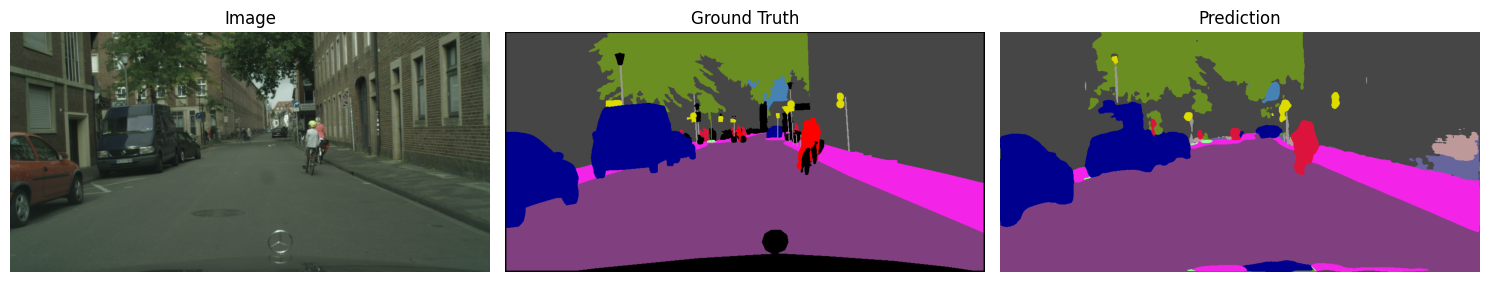

In [17]:
# Quick visualization on one sample
model.eval()
img, mask = val_ds[65]
with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device))
    pred = torch.argmax(pred, dim=1).cpu().numpy()[0]

img_np = img.permute(1,2,0).numpy()
gt_rgb = decode_segmap(mask.numpy())
pred_rgb = decode_segmap(pred)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow((img_np * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406]))); plt.title('Image'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(gt_rgb); plt.title('Ground Truth'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(pred_rgb); plt.title('Prediction'); plt.axis('off')
plt.tight_layout(); plt.show()